# Problem: 

Marker der Becher sind aufgrund der perspektivischen Anordnung der Kamwera, der perspektivischen Verzerrung durch die Kameraapertur und durch die 4-Punkt-Kalibrierung so sehr verzerrt, dass die Marker selbst nicht mehr erkannt werden. 

# Idee
Bildverarbeitung so, dass unter Berücksichtigung einer mittleren Verzerrung, die Marker in der vorderen Becherreihe erkannt werden können. 

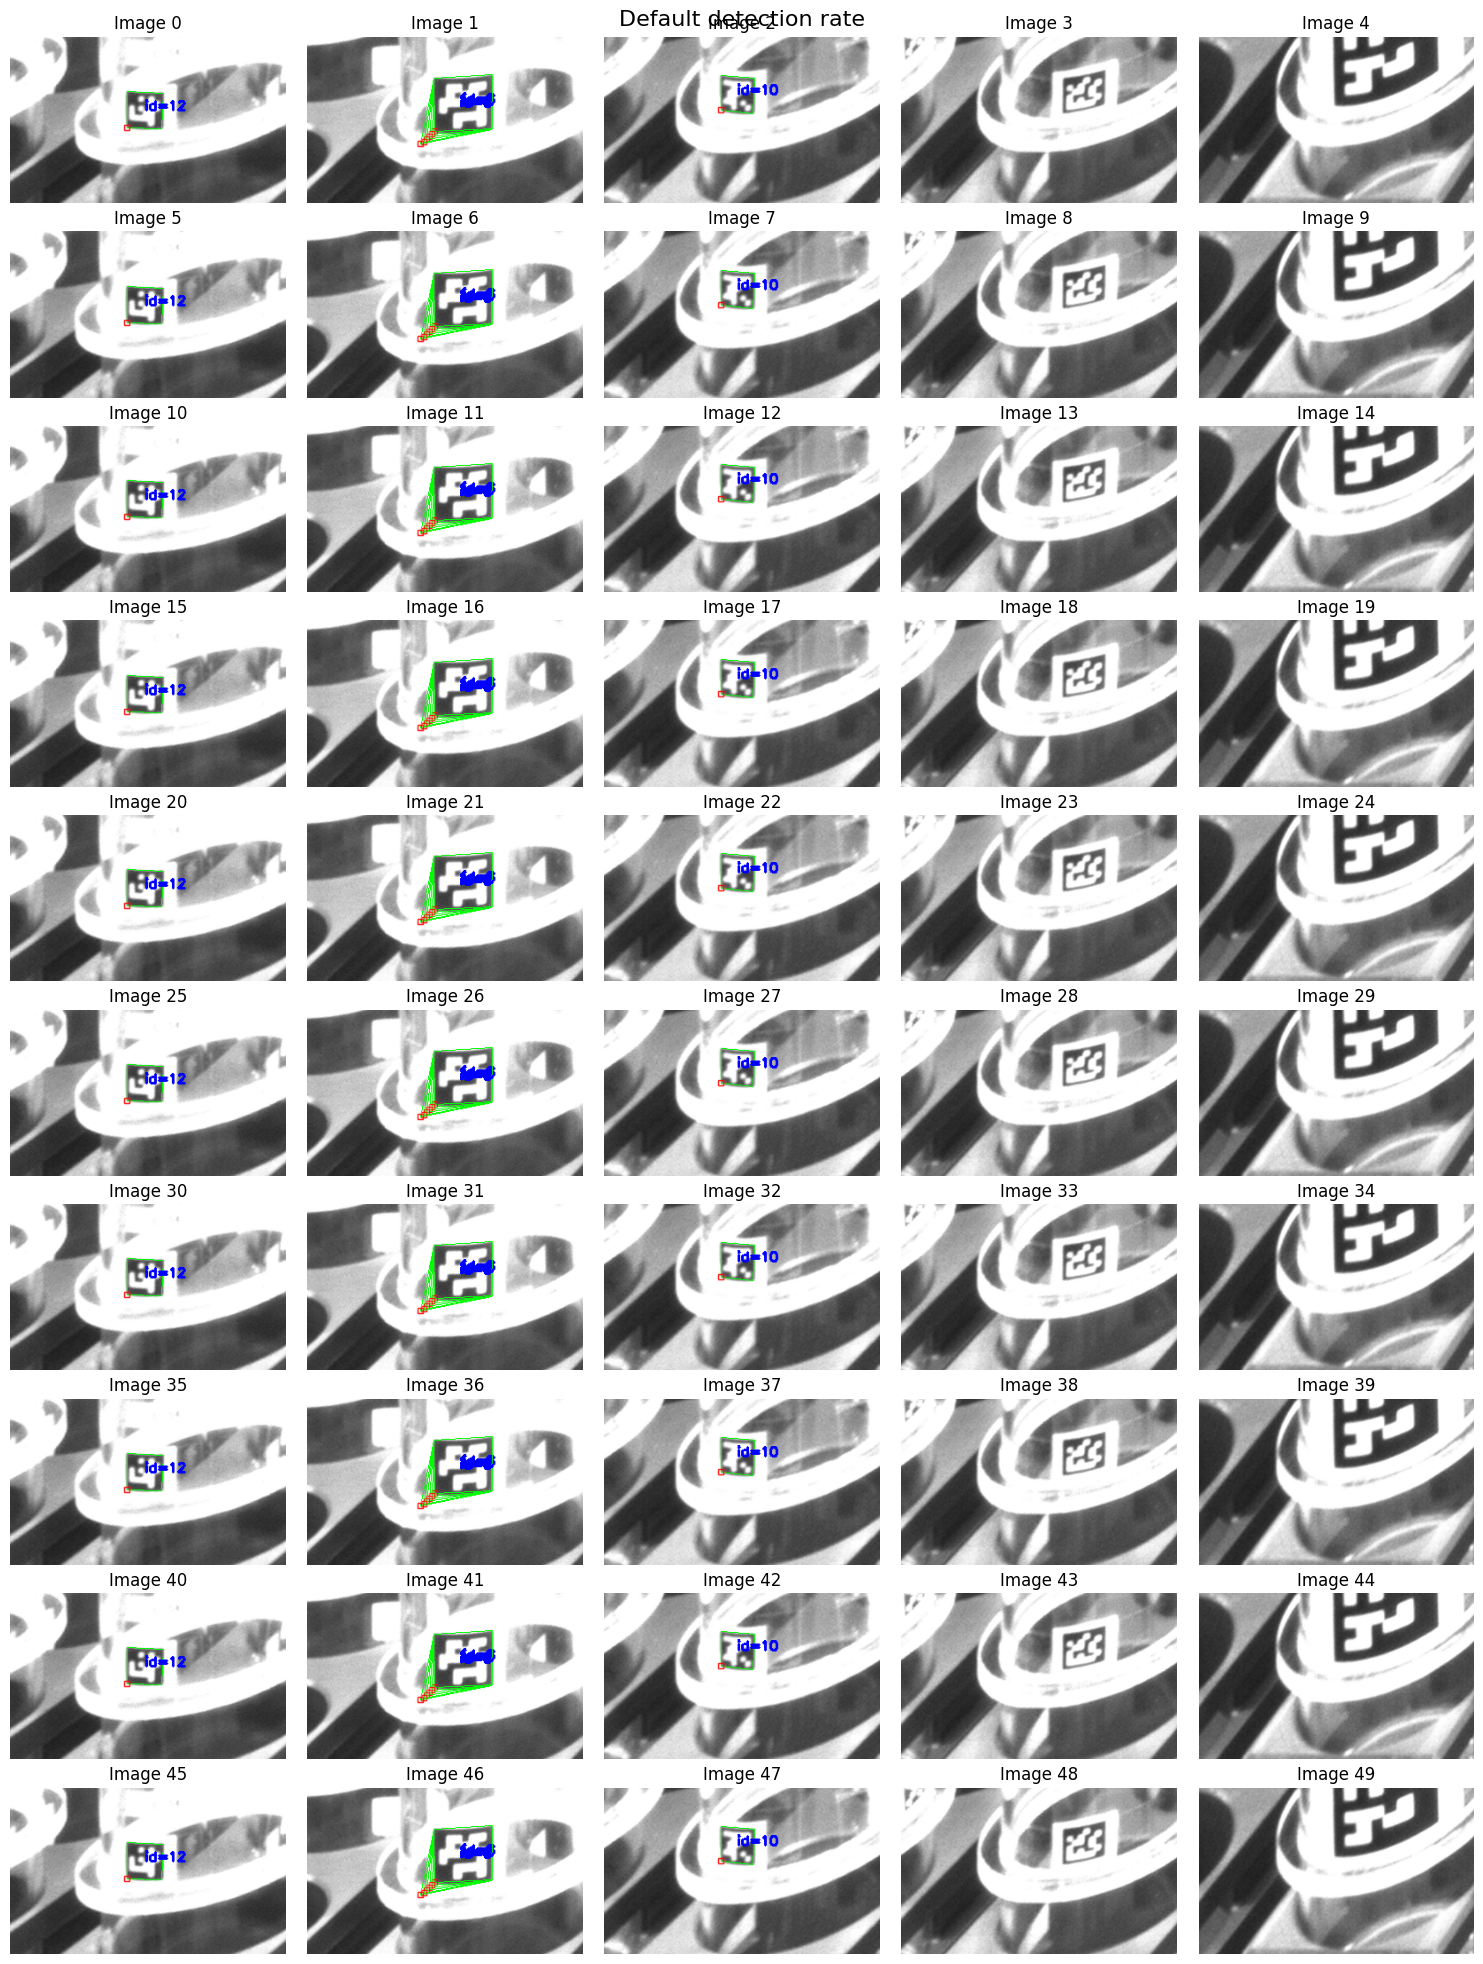

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage as sk

# read in all images and save them in a dict
images = {}
images[0] = cv2.imread('marker/cup4.png')
images[1] = cv2.imread('marker/cup6.png')
images[2] = cv2.imread('marker/cup10.png')
images[3] = cv2.imread('marker/cup11.png')
images[4] = cv2.imread('marker/cup17.png')

# create a bool list which represents which marker is detectable in prinicipal. 
verificationlist = [True, True, True, True, False]

# load aruco dict
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

# perform detection 10 times for each image with default parameters
default = np.zeros((10, 5), dtype=object)
for i in range(10):
    for j in range(5):
        default[i][j] = images[j]
        corners, ids, rejected = cv2.aruco.detectMarkers(images[j], aruco_dict)
        default[i][j] = cv2.aruco.drawDetectedMarkers(images[j], corners, ids) if ids is not None else images[j]

# Create a subplot with all images in default
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
fig.suptitle('Default detection rate', fontsize=16)

# Iterate over the images in default and plot them
for i in range(10):
    for j in range(5):
        axs[i, j].imshow(cv2.cvtColor(default[i][j], cv2.COLOR_BGR2RGB))
        axs[i, j].set_title(f"Image {i*5 + j}")
        axs[i, j].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
        

## Conlusion: 
It is not necessary to repeat Detection exept conditions change. Detection rate is stable



# Try to upscale image to increase marker size. 


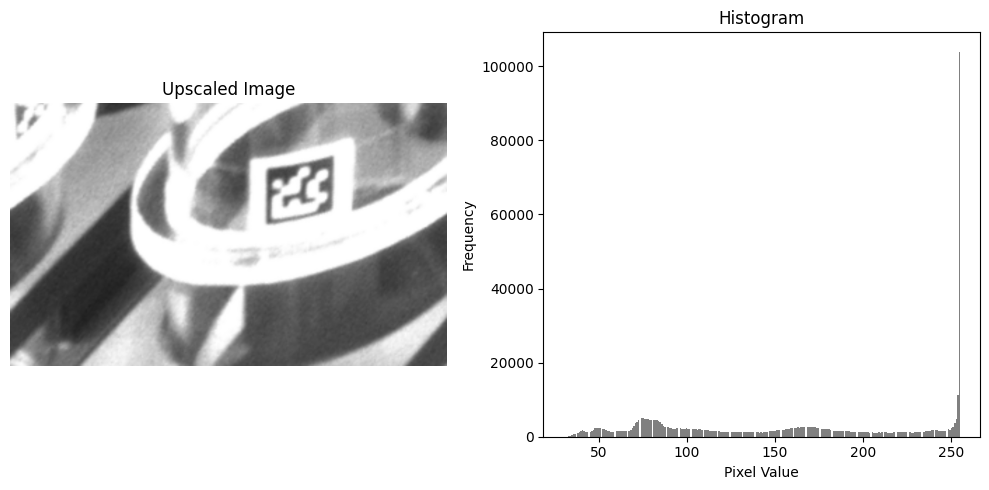

In [213]:
# Upscale the image at index 3
upscaled_image = cv2.resize(images[3], (images[3].shape[1]*3, images[3].shape[0]*3))

# Display the upscaled image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the upscaled image
axs[0].imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Upscaled Image')
axs[0].axis('off')

# Plot the histogram of the upscaled image
axs[1].hist(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY).flatten(), bins=256, color='gray')
axs[1].set_title('Histogram')
axs[1].set_xlabel('Pixel Value')
axs[1].set_ylabel('Frequency')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()



## Detection

Conclusion: Detection of not-too hard distorted markers can be improved, if image is resized in that way, that the marker has roughly the indteded size. 

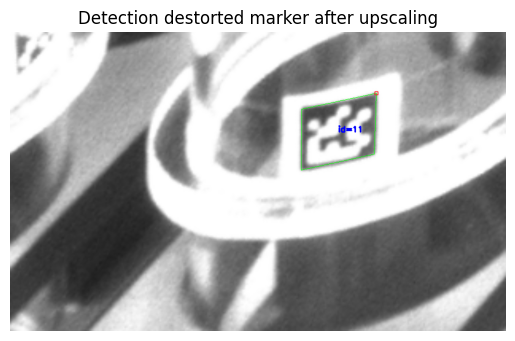

In [214]:
corners, ids, rejected = cv2.aruco.detectMarkers(upscaled_image, aruco_dict)
detected_upscaled = cv2.aruco.drawDetectedMarkers(upscaled_image, corners, ids)

# Display the detected markers
plt.imshow(cv2.cvtColor(detected_upscaled, cv2.COLOR_BGR2RGB))
plt.title('Detection destorted marker after upscaling')
plt.axis('off')
plt.show()



# Old Image referenced in bachelor paper



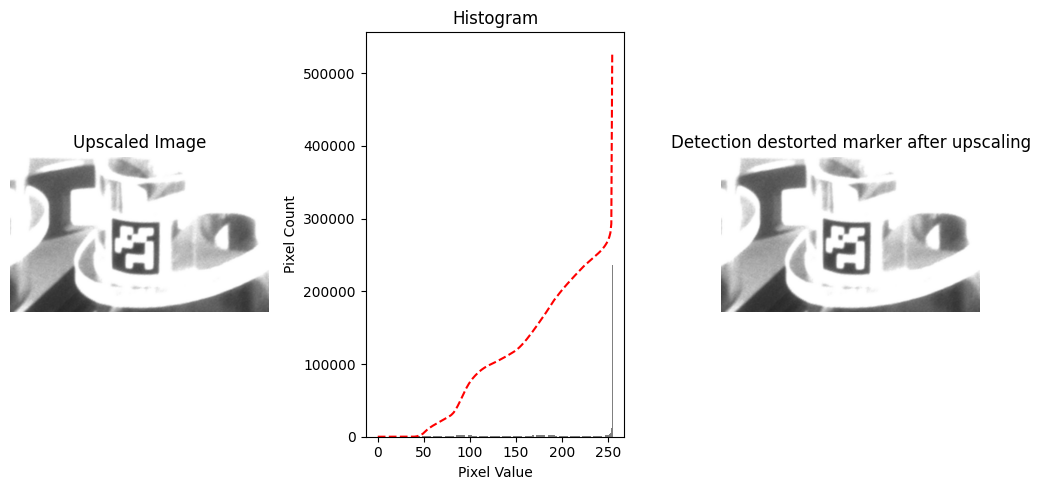

In [215]:
# Upscale the image at index 3
image = cv2.imread('marker/cup6_alt.png')
upscaled_image = cv2.resize(image, (image.shape[1]*3, image.shape[0]*3))
corners, ids, rejected = cv2.aruco.detectMarkers(upscaled_image, aruco_dict)
detected_upscaled = cv2.aruco.drawDetectedMarkers(upscaled_image, corners, ids)

# Calculate the histogram of the upscaled image
histogram, _ = np.histogram(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY).flatten(), bins=256, range=[0, 256])

# Calculate the cumulative distribution using list comprehension and lambda
cumulative_dist = [sum(histogram[:i+1]) for i, _ in enumerate(histogram)]

target_percent = 0.8
index = cumulative_dist.index(max([i for i in cumulative_dist if i <= target_percent*max(cumulative_dist)]))

bins = np.arange(256)
plt.show()

# Display the upscaled image
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the upscaled image
axs[0].imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Upscaled Image')
axs[0].axis('off')

# Plot the histogram of the upscaled image
axs[1].bar(bins, histogram, color='gray')
axs[1].plot(bins, cumulative_dist, 'r--')
axs[1].set_title('Histogram')
axs[1].set_xlabel('Pixel Value')
axs[1].set_ylabel('Pixel Count')

axs[2].imshow(detected_upscaled)
axs[2].set_title('Detection destorted marker after upscaling')
axs[2].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plots
plt.show()


Since this doesnt work either, the theory about too high distortion seems to be correct. 
Maybe an algorithm can be developed to undistort the image enough.
Note: The distortion seem to result from a mix of camera distortion, cylindircal distortion and distortion through 4-point warping. 


Idea: 

Regarding the histogram, the marker area seem to be easily locatable. 


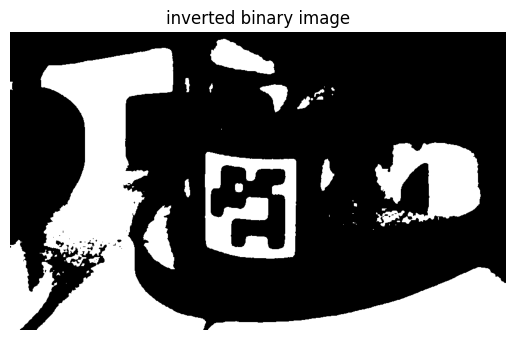

In [216]:
# Convert the upscaled_image to grayscale
gray_image = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create a binary image
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

binary_image = np.array(binary_image)
for i in range(binary_image.shape[0]):
    for j in range(binary_image.shape[1]):
        if binary_image[i][j] == 255:
            binary_image[i][j] = 0
        elif binary_image[i][j] == 0:
            binary_image[i][j] = 255
# Display the upscaled_image with the detected lines
plt.imshow(binary_image, cmap='gray')
plt.title('inverted binary image')
plt.axis('off')
plt.show()


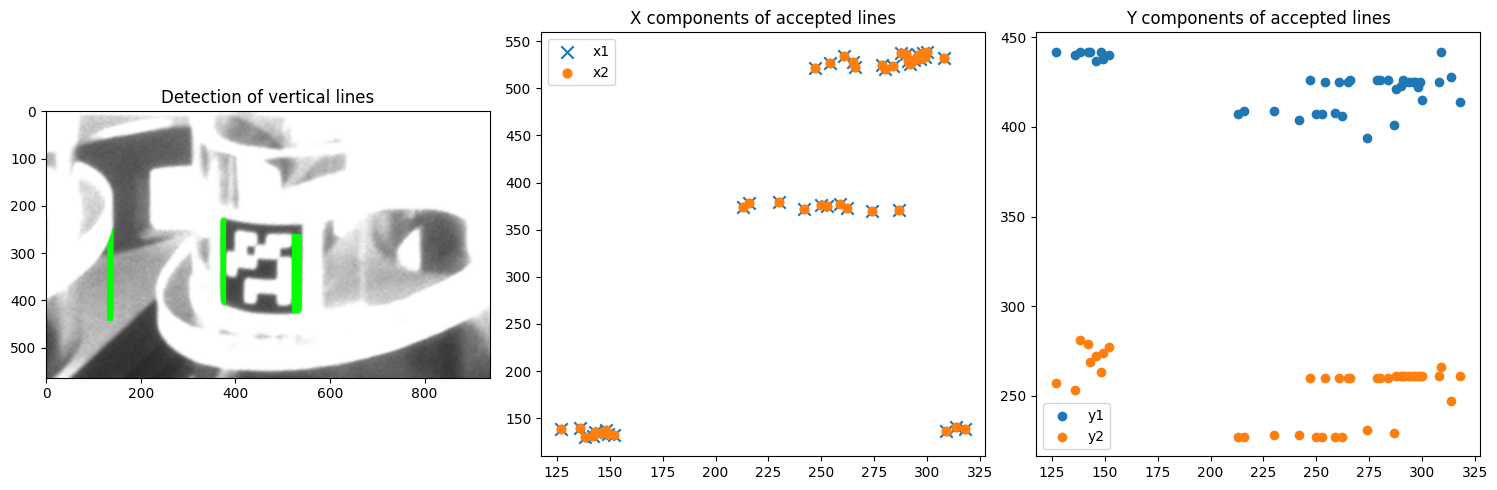

In [217]:
lines = cv2.HoughLinesP(binary_image, 1, np.pi/2, threshold=100, minLineLength=100, maxLineGap=10)
vertical_lines = []
idx_list  = []
angle_list = []
length_list = []
x1_list = []
x2_list = []
y1_list = []
y2_list = []
for idx, line in enumerate(lines):
    x1, y1, x2, y2 = line[0]
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    angle = abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
    eval_angle = 85 < angle < 95
    eval_length = 140 < length < 240
    eval_x = x1 < upscaled_image.shape[1]/2 and x2 < upscaled_image.shape[1]/2 or x2 > upscaled_image.shape[1]/2 and x1 > upscaled_image.shape[1]/2
    eval_y = y1 < upscaled_image.shape[0]/2 and y2 > upscaled_image.shape[0]/2 or y2 < upscaled_image.shape[0]/2 and y1 > upscaled_image.shape[0]/2
    evals = [eval_angle, eval_length, eval_x, eval_y]
    if all(evals):
        vertical_lines.append(line)
        idx_list.append(idx)
        angle_list.append(angle)
        length_list.append(length)
        x1_list.append(x1)
        x2_list.append(x2)
        y1_list.append(y1)
        y2_list.append(y2)
        cv2.line(upscaled_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # print(f"{idx+1}.Line {line} is vertical with angle {angle} degrees and length {length} pixels")

# Display the image with the detected vertical lines
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
ax[0].set_title('Detection of vertical lines')
ax[1].scatter(idx_list, x1_list, label='x1', marker='x', s=80)
ax[1].scatter(idx_list, x2_list, label='x2', marker='o', s=40)
ax[1].legend()
ax[1].set_title('X components of accepted lines')
ax[2].scatter(idx_list, y1_list, label='y1')
ax[2].scatter(idx_list, y2_list, label='y2')
ax[2].legend()
ax[2].set_title('Y components of accepted lines')
plt.tight_layout()
plt.show()

### Idea: Find all lines which length is roughly the same as the horizontal distance to another line. 

For this, I must calculate the horizontal distance from each line to every other lines. 
Define a robust tolerance value

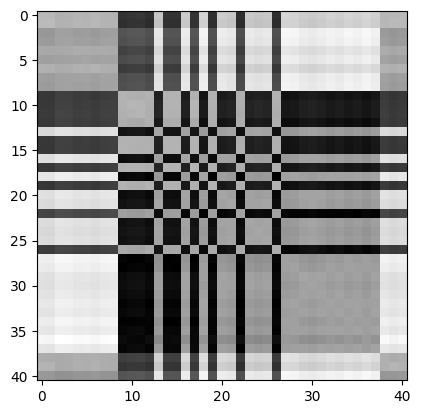

In [220]:
H = np.ones((len(vertical_lines), len(vertical_lines)))
for h, hline in enumerate(vertical_lines):
    for v, vline in enumerate(vertical_lines):
        H[h][v] = abs(abs(x1_list[h] - x1_list[v]) - length_list[h])

plt.imshow(H, cmap='gray')
plt.show()